train data -> N:51542, Y:7657 개

0, np.nan 값 다 드랍

매년 전기 에너지 사용량 달별로 더해서 컬럼 12개로 압축

log 변환

Y,N 그룹 별 각 컬럼간 상관도 ->pairplot

Y,N 그룹 별 각 컬럼의 평균값 barplot

Y,N 그룹 별 각 컬럼의 분포도 box plot

Y,N 그룹 별 각 컬럼의 분포도 dist plot

Y,N 그룹 별 건물용도 별 각 컬럼의 분포도 boxplot

각 컬럼의 NuLL값 주거용도 별 펑균값으로 채우고 예측 - >  정확도: 0.8371, 정밀도: 0.8426, 재현율: 0.1431,    F1: 0.2446, AUC:0.5685
너무 쉽게 N으로 판단(TN 엄청 많음) -> N의 0값의 비중이 너무 큼 ->  Y의 0을 그냥 N으로 판단하는듯 -> 0부터 어떻게 해야함!

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    

In [16]:
def visualize_silhouette(cluster_lists, X_features,cluster_labels): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        #clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        #cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n'+'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
        

In [17]:
def kmeans_plot(clusterDF,n_clusters,max_iter):

    kmeans = KMeans(n_clusters, init='k-means++', max_iter=200, random_state=0)
    cluster_labels = kmeans.fit_predict(clusterDF)
    col=clusterDF.columns
    clusterDF['kmeans_label']  = cluster_labels

#cluster_centers_ 는 개별 클러스터의 중심 위치 좌표 시각화를 위해 추출
    centers = kmeans.cluster_centers_
    unique_labels = np.unique(cluster_labels)
    markers=['o', 's', '^', 'P','D','H','x']

# 군집된 label 유형별로 iteration 하면서 marker 별로 scatter plot 수행. 
    for label in unique_labels:
        label_cluster = clusterDF[clusterDF['kmeans_label']==label]
        center_x_y = centers[label]
        plt.scatter(x=label_cluster[col[0]], y=label_cluster[col[1]], edgecolor='k', 
                    marker=markers[label] )
    
    # 군집별 중심 위치 좌표 시각화 
        plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white',
                    alpha=0.9, edgecolor='k', marker=markers[label])
        plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', 
                    marker='$%d$' % label)

    plt.show()

In [50]:
def plot_mean(df_n):
    index = np.array(df_n.mean().index)
    height = np.array(df_n.mean())
    plt.figure(figsize=(16,10))
    plt.bar(index, height)
    
def plot_dist(df):
    list_series = df.columns
    n=len(list_series)
    plt.figure(figsize=(25,6))
    fig , axes = plt.subplots(n//2+1,2,figsize=(15,40))
    axx = axes.flatten()
    for index,i in enumerate(list_series[:-2]):
        x=df[i]
        sns.distplot(x, kde=True, rug=False,ax=axx[index])
    
def elec_month(df_y):
    df_y_local = df_y.drop(['label','bldng_us'],axis=1)
    for i in range(1,13):
        col = '{0} month'.format(i)
        df_y_local[col]=df_y_local.iloc[:,(i-1)::12].sum(axis=1)
    df_y_local = df_y_local.iloc[:,-1:-13:-1]
    df_y_local = df_y_local.iloc[:,-1:-13:-1]
    df_y_local['bldng_us']=df_y['bldng_us']
    df_y_local['label']=df_y['label']
    return df_y_local

def plot_box1(df,label,h=None):
    list_series = df.columns
    n=len(list_series)
    #fig , axes = plt.subplots(4,n//4+1,figsize=(15,15))
    #axx = axes.flatten()
    if(h==None):
        fig , axes = plt.subplots(4,n//4+1,figsize=(15,15))
        axx = axes.flatten()
        for index,i in enumerate(list_series[:-2]):
            sns.boxplot(i, label, data=df,ax=axx[index])
            #sns.stripplot(x, 'bldng_us',hue=label, data=df, jitter=True, color="0.4",ax=axx[index])
    else:
        fig , axes = plt.subplots(4,n//4+1,figsize=(15,150))
        axx = axes.flatten()
        for index,i in enumerate(list_series[:-2]):
            sns.boxplot(i, label,hue=h ,data=df,ax=axx[index])
            #sns.stripplot(x, 'bldng_us',hue=label, data=df, jitter=True, color="0.4",ax=axx[index])
        

def plot_box2(df,label):
    list_series = df.columns
    n=len(list_series)
    fig , axes = plt.subplots(4,n//4+1,figsize=(15,150))
    axx = axes.flatten()
    for index,i in enumerate(list_series[:-2]):
        sns.boxplot(i, label,hue='bldng_us', data=df,ax=axx[index])
        #sns.stripplot(x, 'bldng_us',hue=label, data=df, jitter=True, color="0.4",ax=axx[index])
        

def fill_elec(df):
    list_ = list(df.columns[:-2])
    for i in list_:
        df[i] = df[i].apply(lambda x: np.nan if x==0 else x)
        #df[i].fillna(df[i].mean(), inplace=True)
        df=df.dropna()
    return df

def circum_plot(df,year,drop=False):
    df_elec = df.iloc[:,18:137:2]
    if drop==True:
        list_ = list(df_elec.columns)
        for i in list_:
            df_elec[i] = df_elec[i].apply(lambda x: np.nan if x==0 else x)
    df_elec=df_elec.dropna()
    df_elec = df_elec.apply(lambda x: np.log10(1+x))
    #list_col = list(df.columns)
    #index = list_col.index('bldng_cnt')
    #df_cir=df.iloc[:,index:index+3]
    df_cir=df.iloc[:,12:17]
    list_cir = list(df_cir.columns)
    df_elec = pd.concat([df_elec,df_cir],axis=1)
    df_elec['fr_yn']=df['fr_yn']
    #df_elec['mon'] = df['dt_of_fr'].apply(lambda x: int(x.split('-')[1]))
    col='ele_engry_us_'
    year=str(year)
    for i in range(1,11):
        if(i<=9):
            mon='0'+str(i)
        else:
            mon=str(i)
        col_a =col+year+mon
        fig =plt.figure(figsize=(10,12))
        ax1 = fig.add_subplot(3, 2, 1)
        ax2 = fig.add_subplot(3, 2, 2)
        ax3 = fig.add_subplot(3, 2, 3)
        ax4 = fig.add_subplot(3, 2, 4)
        ax5 = fig.add_subplot(3, 2, 5)
        list_ax=[ax1, ax2, ax3, ax4, ax5]
        for index,j in enumerate(list_cir):
            df_elec_1=df_elec[df_elec['mon']==i][[col_a,j]]
            list_ax[index].set_xlabel(col_a)
            list_ax[index].set_ylabel(j)
            list_ax[index].set_title(year)
            list_ax[index].scatter(df_elec_1.iloc[:,0],df_elec_1.iloc[:,1])
            

def df_buli(df,drop):
    df_elec = df.iloc[:,18:137:2]
    df_elec=df_elec.iloc[:,30:]
    list_col = list(df.columns)
    index = list_col.index('bldng_cnt')
    df_cir=df.iloc[:,index:index+3]
    
    a=get_outlier(df_cir,'bldng_cnt')
    df_cir.drop(a,axis=0,inplace=True)
    b=get_outlier(df_cir,'bldng_ar')
    df_cir.drop(b,axis=0,inplace=True)
    c=get_outlier(df_cir,'ttl_ar')
    df_cir.drop(c,axis=0,inplace=True)
    
    df_elec = pd.concat([df_elec,df_cir],axis=1)
    list_cir = list(df_cir.columns)
    if drop==True:
        list_ = list(df_elec.columns[:-4])
        for i in list_:
            df_elec[i] = df_elec[i].apply(lambda x: np.nan if x==0 else x)
            
    df_elec=df_elec.dropna()
    
    df_elec.iloc[:,:-4] = df_elec.iloc[:,:-4].apply(lambda x: np.log10(1+x))
    return df_elec

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [51]:
df = pd.read_csv("PJT002_train.csv")
df_vali = pd.read_csv('PJT002_validation.csv')
df.head(3)
df_k = df_buli(df,True)
df_k.head()
df_k.shape
#df_elec = df_k.iloc[:,:-3]
#df_elec=df_elec.iloc[:,30:]
#x=[]
#for i in list(df_elec.columns):
   # a=df_elec[df_elec[i]!=0].shape[0]
    #x.append(a)
#print(x)
#print(x.index(6943))
#df_elec.head()

(2265, 33)

In [52]:
a=df_k.loc[:,['ele_engry_us_201807','bldng_cnt','bldng_ar','ttl_ar']]
b=df_k.loc[:,['ele_engry_us_201807','bldng_cnt']]
c=df_k.loc[:,['ele_engry_us_201807','bldng_ar']]
d=df_k.loc[:,['ele_engry_us_201807','ttl_ar']]
a.shape

(2265, 4)

In [53]:
import matplotlib.pyplot as plt
def kshift_plot(clusterDF):
    col=clusterDF.columns
    best_bandwidth = estimate_bandwidth(clusterDF, quantile=0.2)

    meanshift= MeanShift(best_bandwidth)
    cluster_labels = meanshift.fit_predict(clusterDF)

    clusterDF['meanshift_label']  = cluster_labels
    centers = meanshift.cluster_centers_
    unique_labels = np.unique(cluster_labels)
    markers=['o', 's', '^', 'x', '*']

    for label in unique_labels:
        label_cluster = clusterDF[clusterDF['meanshift_label']==label]
        center_x_y = centers[label]
    # 군집별로 다른 marker로 scatter plot 적용
        plt.scatter(x=label_cluster[col[0]], y=label_cluster[col[1]], edgecolor='k', 
                    marker=markers[label] )
    
    # 군집별 중심 시각화
        plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white',
                    edgecolor='k', alpha=0.9, marker=markers[label])
        plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', 
                    marker='$%d$' % label)
    
    plt.show()

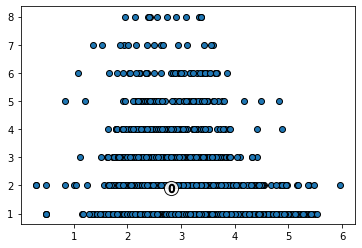

In [54]:
kshift_plot(a)

IndexError: list index out of range

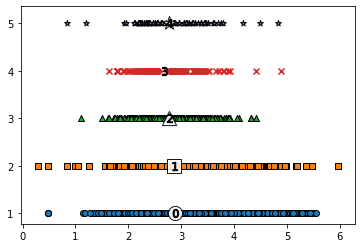

In [55]:
kshift_plot(b)

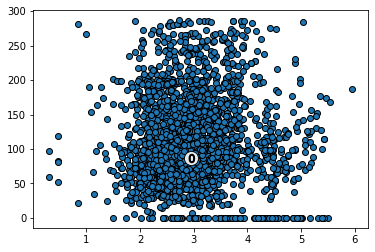

In [56]:
kshift_plot(c)